In [16]:
import numpy as np
import numba as nb
import time
import matplotlib.pylab as plt

# Set plotting_mode to False for pure performance testing
plotting_mode = True
if plotting_mode:
    plt.rcParams['figure.dpi'] = 150

### Constants
# These values are typically not used, but are listed for reference or if needed
#tau_leak = 20/1000
V_E = 14/3
V_I = -2/3
num_E = 300
num_PV = 66
num_SOM = 34
pv_prop = 2/3
som_prop = 1/3
S_EE = 0.0255
S_EPV = 0.052
S_ESOM = 0.026
S_PVE = 0.01
S_PVPV = 0.03
S_PVSOM = 0.01
S_SOME = 0.004
S_SOMPV = 0.04
S_SOMSOM = 0.001
S_amb = 0.003
tau_E = 2/1000
tau_I = 4/1000
h = 1/10000
T = 1
c = 10
lam_E = 0.288*c
lam_PV = 0.972*c
lam_amb = 0.433 * 1000
lam_lat = 0.5
amb_update = S_amb / tau_E
df_EE = 0.8 # E --> E
df_EPV = 0.5 # PV --> E
df_ESOM = -0.3 # SOM --> E
df_PVE = 0.8 # E --> PV
df_PVPV = 0.5 # PV --> PV
df_PVSOM = -0.3 # SOM --> PV
df_SOME = -0.3 # E --> SOM
df_SOMPV = 0.5 # PV --> SOM
df_SOMSOM = 0.3 # SOM --> SOM
td_EE = 0.03
td_EPV = 0.007
td_ESOM = 0.001
td_PVE = 0.03
td_PVPV = 0.007
td_PVSOM = 0.001
td_SOME = 0.001
td_SOMPV = 0.007
td_SOMSOM = 0.007
N = num_E + num_PV + num_SOM
tau_leak = np.random.normal(loc=20, scale=2, size=N) / 1000.0
max_delay_steps = 30

@nb.njit(cache=True)
def create_external_stimuli_fast(lams, N, T, h):
    """
    Numba-compiled function to randomly generate Poisson spike data.
    lams: vector of rate constants of shape (N)
    N: Number of neurons
    T: Length of simulation
    h: Length of one time step
    Returns N x (T/h) matrix of spike times
    """
    num_steps = int(T / h)
    spike_probs = lams * h
    rand_vals = np.random.rand(N, num_steps)
    return (rand_vals < spike_probs.reshape(-1, 1)).astype(np.int8)

def create_neurons_fast(params):
    """
    Optimized function to create neurons and their connectivity.
    Takes in all parameters of the simulation.
    Returns dictionary object representing the set of neurons.
    """
    S_EE, S_EPV, S_ESOM, S_PVE, S_PVPV, S_PVSOM, S_SOME, S_SOMPV, S_SOMSOM, \
    lam_E, lam_PV, lam_lat, \
    df_EE, df_EPV, df_ESOM, df_PVE, df_PVPV, df_PVSOM, df_SOME, df_SOMPV, df_SOMSOM, \
    td_EE, td_EPV, td_ESOM, td_PVE, td_PVPV, td_PVSOM, td_SOME, td_SOMPV, td_SOMSOM = params

    def create_split(a,b,c): return np.concatenate((a*np.ones(num_E), b*np.ones(num_PV), c*np.ones(num_SOM)))
    def create_num_presynaptics(mu, sd, size): return np.clip(np.random.normal(mu, sd, size), mu-sd, mu+sd).astype(np.int64)

    # Generates the number of presynaptic neurons to each postsynaptic neuron, differentiated by neuron type
    e_to_e_presynaptic_counts = create_num_presynaptics(mu = 80, sd = 15, size = num_E)
    pv_to_e_presynaptic_counts = create_num_presynaptics(mu = 50*(pv_prop), sd = 7.5*(pv_prop), size = num_E)
    som_to_e_presynaptic_counts = create_num_presynaptics(mu = 50*(som_prop), sd = 7.5*(som_prop), size = num_E)
    e_to_pv_presynaptic_counts = create_num_presynaptics(mu = 240, sd = 37.5, size = num_PV)
    pv_to_pv_presynaptic_counts = create_num_presynaptics(mu = 50*(pv_prop), sd = 7.5*(pv_prop), size = num_PV)
    som_to_pv_presynaptic_counts = create_num_presynaptics(mu = 50*(som_prop), sd = 7.5*(som_prop), size = num_PV)
    e_to_som_presynaptic_counts = create_num_presynaptics(mu = 240*(som_prop), sd = 37.5*(som_prop), size = num_SOM)
    pv_to_som_presynaptic_counts = create_num_presynaptics(mu = 50*(pv_prop), sd = 7.5*(pv_prop), size = num_SOM)
    som_to_som_presynaptic_counts = create_num_presynaptics(mu = 50*(som_prop), sd = 7.5*(som_prop), size = num_SOM)

    postsynaptics_list = [[] for _ in range(N)]
    postsynaptic_delays_list = [[] for _ in range(N)]
    postsynaptic_dfs_list = [[] for _ in range(N)]
    postsynaptic_tds_list = [[] for _ in range(N)]

    e_indices = np.arange(num_E, dtype=np.int64)
    pv_indices = np.arange(num_E, num_E + num_PV, dtype=np.int64)
    som_indices = np.arange(num_E + num_PV, N, dtype=np.int64)

    # Loop assigns presynaptic neurons to their postsynaptic targets along with the synaptic delay and the depression/facilitation factor
    for i in range(N):
        # i represents index of postsynaptic neuron
        if i < num_E:
            e_count, pv_count, som_count = e_to_e_presynaptic_counts[i], pv_to_e_presynaptic_counts[i], som_to_e_presynaptic_counts[i]
            e_delays = np.random.uniform(1, 2.3, e_count) / 1000.0
            depression_factors = np.concatenate((df_EE*np.ones(e_count), df_EPV*np.ones(pv_count), df_ESOM*np.ones(som_count)))
            tau_depressions = np.concatenate((td_EE*np.ones(e_count), td_EPV*np.ones(pv_count), td_ESOM*np.ones(som_count)))
        elif i < num_E + num_PV:
            e_count, pv_count, som_count = e_to_pv_presynaptic_counts[i - num_E], pv_to_pv_presynaptic_counts[i - num_E], som_to_pv_presynaptic_counts[i - num_E]
            e_delays = np.ones(e_count) / 1000.0
            depression_factors = np.concatenate((df_PVE*np.ones(e_count), df_PVPV*np.ones(pv_count), df_PVSOM*np.ones(som_count)))
            tau_depressions = np.concatenate((td_PVE*np.ones(e_count), td_PVPV*np.ones(pv_count), td_PVSOM*np.ones(som_count)))
        else:
            e_count, pv_count, som_count = e_to_som_presynaptic_counts[i - num_E - num_PV], pv_to_som_presynaptic_counts[i - num_E - num_PV], som_to_som_presynaptic_counts[i - num_E - num_PV]
            e_delays = np.ones(e_count) / 1000.0
            depression_factors = np.concatenate((df_SOME*np.ones(e_count), df_SOMPV*np.ones(pv_count), df_SOMSOM*np.ones(som_count)))
            tau_depressions = np.concatenate((td_PVE*np.ones(e_count), td_SOMPV*np.ones(pv_count), td_SOMSOM*np.ones(som_count)))
        
        pv_delays, som_delays = np.random.uniform(0.8, 1.5, pv_count) / 1000.0, np.random.uniform(0.8, 1.5, som_count) / 1000.0
        e_presynaptic, pv_presynaptic, som_presynaptic = np.random.choice(np.setdiff1d(e_indices, i), e_count, replace=False), np.random.choice(np.setdiff1d(pv_indices, i), pv_count, replace=False), np.random.choice(np.setdiff1d(som_indices, i), som_count, replace=False)
        presynaptic_neurons, delays = np.concatenate((e_presynaptic, pv_presynaptic, som_presynaptic)), np.concatenate((e_delays, pv_delays, som_delays))

        for idx, presynaptic_neuron in enumerate(presynaptic_neurons):
            postsynaptics_list[presynaptic_neuron].append(i)
            postsynaptic_delays_list[presynaptic_neuron].append(delays[idx])
            postsynaptic_dfs_list[presynaptic_neuron].append(depression_factors[idx])
            postsynaptic_tds_list[presynaptic_neuron].append(tau_depressions[idx])

    neurons = {
        'potential': np.random.rand(N), 
        'gE': np.concatenate((np.random.uniform(0, 90, num_E), np.random.uniform(0, 60, num_PV + num_SOM))),
        'gI': np.concatenate((np.random.uniform(0, 330, num_E), np.random.uniform(0, 400, num_PV + num_SOM))),
        'refractory_end_time': np.random.uniform(0, 0.002, N),#np.zeros(N), 
        'type': create_split(1, 0, -1),
        'E_Update': create_split(S_EE, S_PVE, S_SOME) / tau_E, 
        'PV_Update': create_split(S_EPV, S_PVPV, S_SOMPV) / tau_I,
        'SOM_Update': create_split(S_ESOM, S_PVSOM, S_SOMSOM) / tau_I,
        'spike_times': [[] for _ in range(N)],#np.zeros((N, int(T/h))),
        'synapse_values': np.ones((N, N)), 
        'synapse_last_update_times': np.zeros((N, N))
    }
    
    lams_ext = create_split(lam_E * 1000, lam_PV * 1000, 0)
    lams_lat = create_split(0, lam_lat * 1000, lam_lat * 1000)
    neurons['feedforward_spike_times'] = create_external_stimuli_fast(lams_ext, N, T, h)
    neurons['ambient_spike_times'] = create_external_stimuli_fast(np.full(N, lam_amb), N, T, h)
    neurons['lateral_spike_times'] = create_external_stimuli_fast(np.full(N, lams_lat), N, T, h)
    neurons['postsynaptics'] = np.concatenate(postsynaptics_list).astype(np.int64)
    neurons['postsynaptic_delays'] = np.concatenate(postsynaptic_delays_list)
    neurons['postsynaptic_dfs'] = np.concatenate(postsynaptic_dfs_list)
    neurons['tau_depression'] = np.concatenate(postsynaptic_tds_list)
    neurons['postsynaptic_ids'] = np.cumsum(np.array([0] + [len(arr) for arr in postsynaptics_list])).astype(np.int64)
    return neurons

@nb.njit(cache=True)
def _calculate_cv_from_bins(binned_counts):
    """Calculates CV from a numpy array of binned spike counts."""
    mean_counts = np.mean(binned_counts)
    if mean_counts < 1e-9: # Avoid division by zero if the population is silent
        return 0.0
    
    std_dev_counts = np.std(binned_counts)
    return std_dev_counts / mean_counts

@nb.njit(cache=True)
def _run_simulation_numba(
    potential, gE, gI, refractory_end_time, neuron_type, E_Update, PV_Update, SOM_Update,
    tau_depression, synapse_values, synapse_last_update_times,
    postsynaptics, postsynaptic_ids, 
    postsynaptic_delays, postsynaptic_dfs,
    feedforward_spike_times, ambient_spike_times, lateral_spike_times, T, h, tau_leak, V_E, V_I, 
    tau_E, tau_I, amb_update
):
    """
    Numba-compiled function to run the simulation given the neurons. Neuron parameters have to be
    passed in individually due to numba not accepting dictionaries.
    Returns the number of spikes across neuron types, how depressed/facilitated the synapses are,
    the last time each synapse updated, and the timings of all the spikes (if in plotting mode).
    """
    total_E_spikes, total_PV_spikes, total_SOM_spikes = 0, 0, 0
    if plotting_mode: all_spikes = []
    else: all_spikes = 0

    # --- NEW: Setup for Online CV Calculation ---
    # Calculate binning parameters
    bin_size_ms = 5.0
    bin_size_steps = int(round((bin_size_ms / 1000.0) / h))
    if bin_size_steps == 0: bin_size_steps = 1 # Ensure bin size is at least one time step
    num_bins = int(round(T / h)) // bin_size_steps

    # Create arrays to store the binned spike counts for each population
    e_binned_counts = np.zeros(num_bins, dtype=np.float64)
    pv_binned_counts = np.zeros(num_bins, dtype=np.float64)
    som_binned_counts = np.zeros(num_bins, dtype=np.float64)
    # --- End of New Setup ---

    # We maintain a buffer for gE and gI for fast, numba-compatible integration of delayed spikes
    gE_buffer, gI_buffer = np.zeros((N, max_delay_steps)), np.zeros((N, max_delay_steps))
    t = 0.0
    while t < T:
        t_int = int(np.round(t / h))
        buffer_idx = t_int % max_delay_steps
        
        gE += gE_buffer[:, buffer_idx]; gI += gI_buffer[:, buffer_idx]
        gE_buffer[:, buffer_idx] = 0.0; gI_buffer[:, buffer_idx] = 0.0

        # Update based on external spiking
        gE[feedforward_spike_times[:, t_int] == 1] += E_Update[feedforward_spike_times[:, t_int] == 1]
        gE[ambient_spike_times[:, t_int] == 1] += amb_update
        gE[lateral_spike_times[:, t_int] == 1] += E_Update[lateral_spike_times[:, t_int] == 1]
        # Exponential decay
        gE -= h * gE / tau_E; gI -= h * gI / tau_I

        # Updated potential of neurons not in refractory period
        not_in_refractory = (t >= refractory_end_time)
        potential[not_in_refractory] += h * (
            -potential[not_in_refractory]/tau_leak[not_in_refractory] 
            - (potential[not_in_refractory] - V_E)*gE[not_in_refractory] 
            - (potential[not_in_refractory] - V_I)*gI[not_in_refractory]
        )

        spiking_indices = np.where((potential >= 1.0) & not_in_refractory)[0]
        if spiking_indices.size > 0:
            # --- NEW: Populate Bins with Spike Counts ---
            current_bin = t_int // bin_size_steps
            if current_bin < num_bins:
                # Efficiently count spikes per type using the neuron_type array
                types_of_spikers = neuron_type[spiking_indices]
                e_binned_counts[current_bin] += np.sum(types_of_spikers == 1)
                pv_binned_counts[current_bin] += np.sum(types_of_spikers == 0)
                som_binned_counts[current_bin] += np.sum(types_of_spikers == -1)

            for spiking_neuron in spiking_indices:
                neuron_class = neuron_type[spiking_neuron]
                if t > 0.2:
                    if neuron_class == 1: total_E_spikes += 1
                    elif neuron_class == 0: total_PV_spikes += 1
                    else: total_SOM_spikes += 1

                potential[spiking_neuron] = 0.0
                refractory_end_time[spiking_neuron] = t + 2.0/1000

                # Postsynaptic IDs downstream of spiking neuron lie between these two indices
                post_start, post_end = postsynaptic_ids[spiking_neuron], postsynaptic_ids[spiking_neuron + 1]
                
                for i in range(post_start, post_end):
                    downstream_neuron = postsynaptics[i]
                    
                    last_val = synapse_values[spiking_neuron, downstream_neuron]
                    last_t = synapse_last_update_times[spiking_neuron, downstream_neuron]
                    
                    time_elapsed = t - last_t
                    tau = tau_depression[i]
                    transmitter_val = 1.0 + (last_val - 1.0) * np.exp(-time_elapsed / tau)

                    df = postsynaptic_dfs[i]
                    new_val = transmitter_val * (1 - df)
                    new_val = min(new_val, 10.0)
                    
                    synapse_values[spiking_neuron, downstream_neuron] = new_val
                    synapse_last_update_times[spiking_neuron, downstream_neuron] = t

                    delay = postsynaptic_delays[i]
                    delay_steps = int(round(delay / h))
                    if delay_steps < max_delay_steps:
                        target_idx = (buffer_idx + delay_steps) % max_delay_steps
                        if neuron_type[spiking_neuron] == 1:
                            gE_buffer[downstream_neuron, target_idx] += E_Update[downstream_neuron] * transmitter_val
                        elif neuron_type[spiking_neuron] == 0:
                            gI_buffer[downstream_neuron, target_idx] += PV_Update[downstream_neuron] * transmitter_val
                        else:
                            gI_buffer[downstream_neuron, target_idx] += SOM_Update[downstream_neuron] * transmitter_val

        if plotting_mode and len(spiking_indices) > 0: all_spikes.append((spiking_indices, t_int))
        t += h
    # 40 onwards ignores first 200ms
    cv_E = _calculate_cv_from_bins(e_binned_counts[40:])
    cv_PV = _calculate_cv_from_bins(pv_binned_counts[40:])
    cv_SOM = _calculate_cv_from_bins(som_binned_counts[40:])

    return total_E_spikes, total_PV_spikes, total_SOM_spikes, synapse_values, synapse_last_update_times, all_spikes, cv_E, cv_PV, cv_SOM

def run_simulation(params = np.array([S_EE, S_EPV, S_ESOM, S_PVE, S_PVPV, S_PVSOM, S_SOME, S_SOMPV, S_SOMSOM, 
    lam_E, lam_PV, lam_lat, df_EE, df_EPV, df_ESOM, df_PVE, df_PVPV, df_PVSOM, df_SOME, df_SOMPV, df_SOMSOM,
    td_EE, td_EPV, td_ESOM, td_PVE, td_PVPV, td_PVSOM, td_SOME, td_SOMPV, td_SOMSOM])):
    neurons = create_neurons_fast(params)

    total_E_spikes, total_PV_spikes, total_SOM_spikes, final_vals, final_times, all_spikes, cv_E, cv_PV, cv_SOM = _run_simulation_numba(
        neurons['potential'], neurons['gE'], neurons['gI'], neurons['refractory_end_time'],
        neurons['type'], neurons['E_Update'], neurons['PV_Update'], neurons['SOM_Update'],
        neurons['tau_depression'], neurons['synapse_values'], neurons['synapse_last_update_times'],
        neurons['postsynaptics'], neurons['postsynaptic_ids'],
        neurons['postsynaptic_delays'], neurons['postsynaptic_dfs'],
        neurons['feedforward_spike_times'], neurons['ambient_spike_times'], neurons['lateral_spike_times'],
        T, h, tau_leak, V_E, V_I, tau_E, tau_I, amb_update
    )

    E_rate, PV_rate, SOM_rate = total_E_spikes / (T * num_E), total_PV_spikes / (T * num_PV), total_SOM_spikes / (T * num_SOM)
    
    # 1. Initialize a dense (N,N) matrix with a default value of 1.0 to avoid division by zero.
    tau_depression_dense = np.ones((N, N))

    # 2. Iterate through each presynaptic neuron to map its sparse tau values to the dense matrix.
    for pre_neuron_idx in range(N):
        # Find the slice corresponding to this neuron's connections in the sparse arrays
        start, end = neurons['postsynaptic_ids'][pre_neuron_idx], neurons['postsynaptic_ids'][pre_neuron_idx + 1]
        
        if start == end:  # Skip if the neuron has no outgoing connections
            continue
        
        # Get the indices of its postsynaptic targets
        post_neuron_indices = neurons['postsynaptics'][start:end]
        
        # Get the corresponding tau values from the sparse 1D array
        tau_values = neurons['tau_depression'][start:end]
        
        # 3. Use NumPy's advanced indexing to efficiently place the tau values into the dense matrix.
        tau_depression_dense[pre_neuron_idx, post_neuron_indices] = tau_values

    # --- END: New Reconstruction Code ---

    # 4. Now perform the final calculation using the newly created dense matrix.
    time_elapsed = T - final_times
    final_transmitter_state = 1.0 + (final_vals - 1.0) * np.exp(-time_elapsed / tau_depression_dense)

    EE_block = final_transmitter_state[:num_E, :num_E]
    EPV_block = final_transmitter_state[num_E:num_E + num_PV, :num_E]
    ESOM_block = final_transmitter_state[num_E + num_PV:, :num_E] 
    PVE_block = final_transmitter_state[:num_E, num_E:num_E + num_PV] 
    PVPV_block = final_transmitter_state[num_E:num_E + num_PV, num_E:num_E + num_PV]
    PVSOM_block = final_transmitter_state[num_E + num_PV:, num_E:num_E + num_PV]
    SOME_block = final_transmitter_state[:num_E, num_E + num_PV:] 
    SOMPV_block = final_transmitter_state[num_E:num_E + num_PV, num_E + num_PV:]
    SOMSOM_block = final_transmitter_state[num_E + num_PV:, num_E + num_PV:]
    if plotting_mode:
        for spike_indices, t_int in all_spikes:
            for spiking_neuron in spike_indices:
                if t_int < int(T/h):
                    neurons['spike_times'][spiking_neuron].append(t_int * h)#, t_int] = t_int
    
    blocks, labels = [EE_block, EPV_block, ESOM_block, PVE_block, PVPV_block, PVSOM_block, SOME_block, SOMPV_block, SOMSOM_block], ["EE", "EPV", "ESOM", "PVE", "PVPV", "PVSOM", "SOME", "SOMPV", "SOMSOM"]
    transmitter_means = np.zeros(len(blocks))
    for i, (block, label) in enumerate(zip(blocks, labels)):
        active_connections = block[(block > 1.00001) | (block < 0.99999)] # Check for non-baseline values
        if active_connections.size > 0: transmitter_means[i] = np.mean(active_connections)
        else: transmitter_means[i] = 1
    neurons['transmitter_means'] = transmitter_means
    
    return E_rate, PV_rate, SOM_rate, cv_E, cv_PV, cv_SOM, neurons, labels

import time
if __name__ == '__main__':
    params = np.load('final_params.npy')
    E_rate, PV_rate, SOM_rate, cv_E, cv_PV, cv_SOM, neurons, labels = run_simulation(params)
    
    print(f"\nMean Excitatory Rate: {E_rate:.2f} Hz")
    print(f"Mean PV Rate: {PV_rate:.2f} Hz")
    print(f"Mean SOM Rate: {SOM_rate:.2f} Hz\n")
    print(f"PV/E Ratio: {((PV_rate) / E_rate):.2f}")
    print(f"CV_E: {cv_E:.4f}, CV_PV: {cv_PV:.4f}, CV_SOM: {cv_SOM:.4f}")
    
    print(f"Mean Transmitter Availability at T={T}s:")
    for mean, label in zip(neurons['transmitter_means'], labels):
        print(f"  {label}: {mean:.4f}")


Mean Excitatory Rate: 26.30 Hz
Mean PV Rate: 110.52 Hz
Mean SOM Rate: 37.71 Hz

PV/E Ratio: 4.20
CV_E: 1.0946, CV_PV: 0.8306, CV_SOM: 1.5358
Mean Transmitter Availability at T=1s:
  EE: 0.6292
  EPV: 0.5869
  ESOM: 0.9776
  PVE: 0.6706
  PVPV: 0.4539
  PVSOM: 1.0363
  SOME: 1.4868
  SOMPV: 0.4965
  SOMSOM: 0.9640


In [17]:
labels = ["S_EE", "S_EPV", "S_ESOM", "S_PVE", "S_PVPV", "S_PVSOM", "S_SOME", "S_SOMPV", "S_SOMSOM", "lam_E", "lam_PV", "lam_lat", "df_EE", "df_EPV", "df_ESOM",
          "df_PVE", "df_PVPV", "df_PVSOM", "df_SOME", "df_SOMPV", "df_SOMSOM", "tau_dE", "tau_dPV", 
          "tau_dSOM"]
print("Parameters:")
for i, (label, param) in enumerate(zip(labels, params)):
    print(f"{i}. {label}: {param}")

Parameters:
0. S_EE: 0.02031005173921585
1. S_EPV: 0.044614262878894806
2. S_ESOM: 0.014536923728883266
3. S_PVE: 0.020595019683241844
4. S_PVPV: 0.033624403178691864
5. S_PVSOM: 0.014792541041970253
6. S_SOME: 0.012306686490774155
7. S_SOMPV: 0.03393559902906418
8. S_SOMSOM: 0.0015148604288697243
9. lam_E: 1.8761159181594849
10. lam_PV: 0.8438052535057068
11. lam_lat: 0.2611176371574402
12. df_EE: 0.6217929720878601
13. df_EPV: 0.38052648305892944
14. df_ESOM: 0.5117722749710083
15. df_PVE: 0.39261895418167114
16. df_PVPV: 0.48295456171035767
17. df_PVSOM: -0.9541295766830444
18. df_SOME: -0.22547295689582825
19. df_SOMPV: 0.46692654490470886
20. df_SOMSOM: 0.5718880295753479
21. tau_dE: 0.03274655342102051
22. tau_dPV: 0.009618043899536133
23. tau_dSOM: 0.0031784523744136095


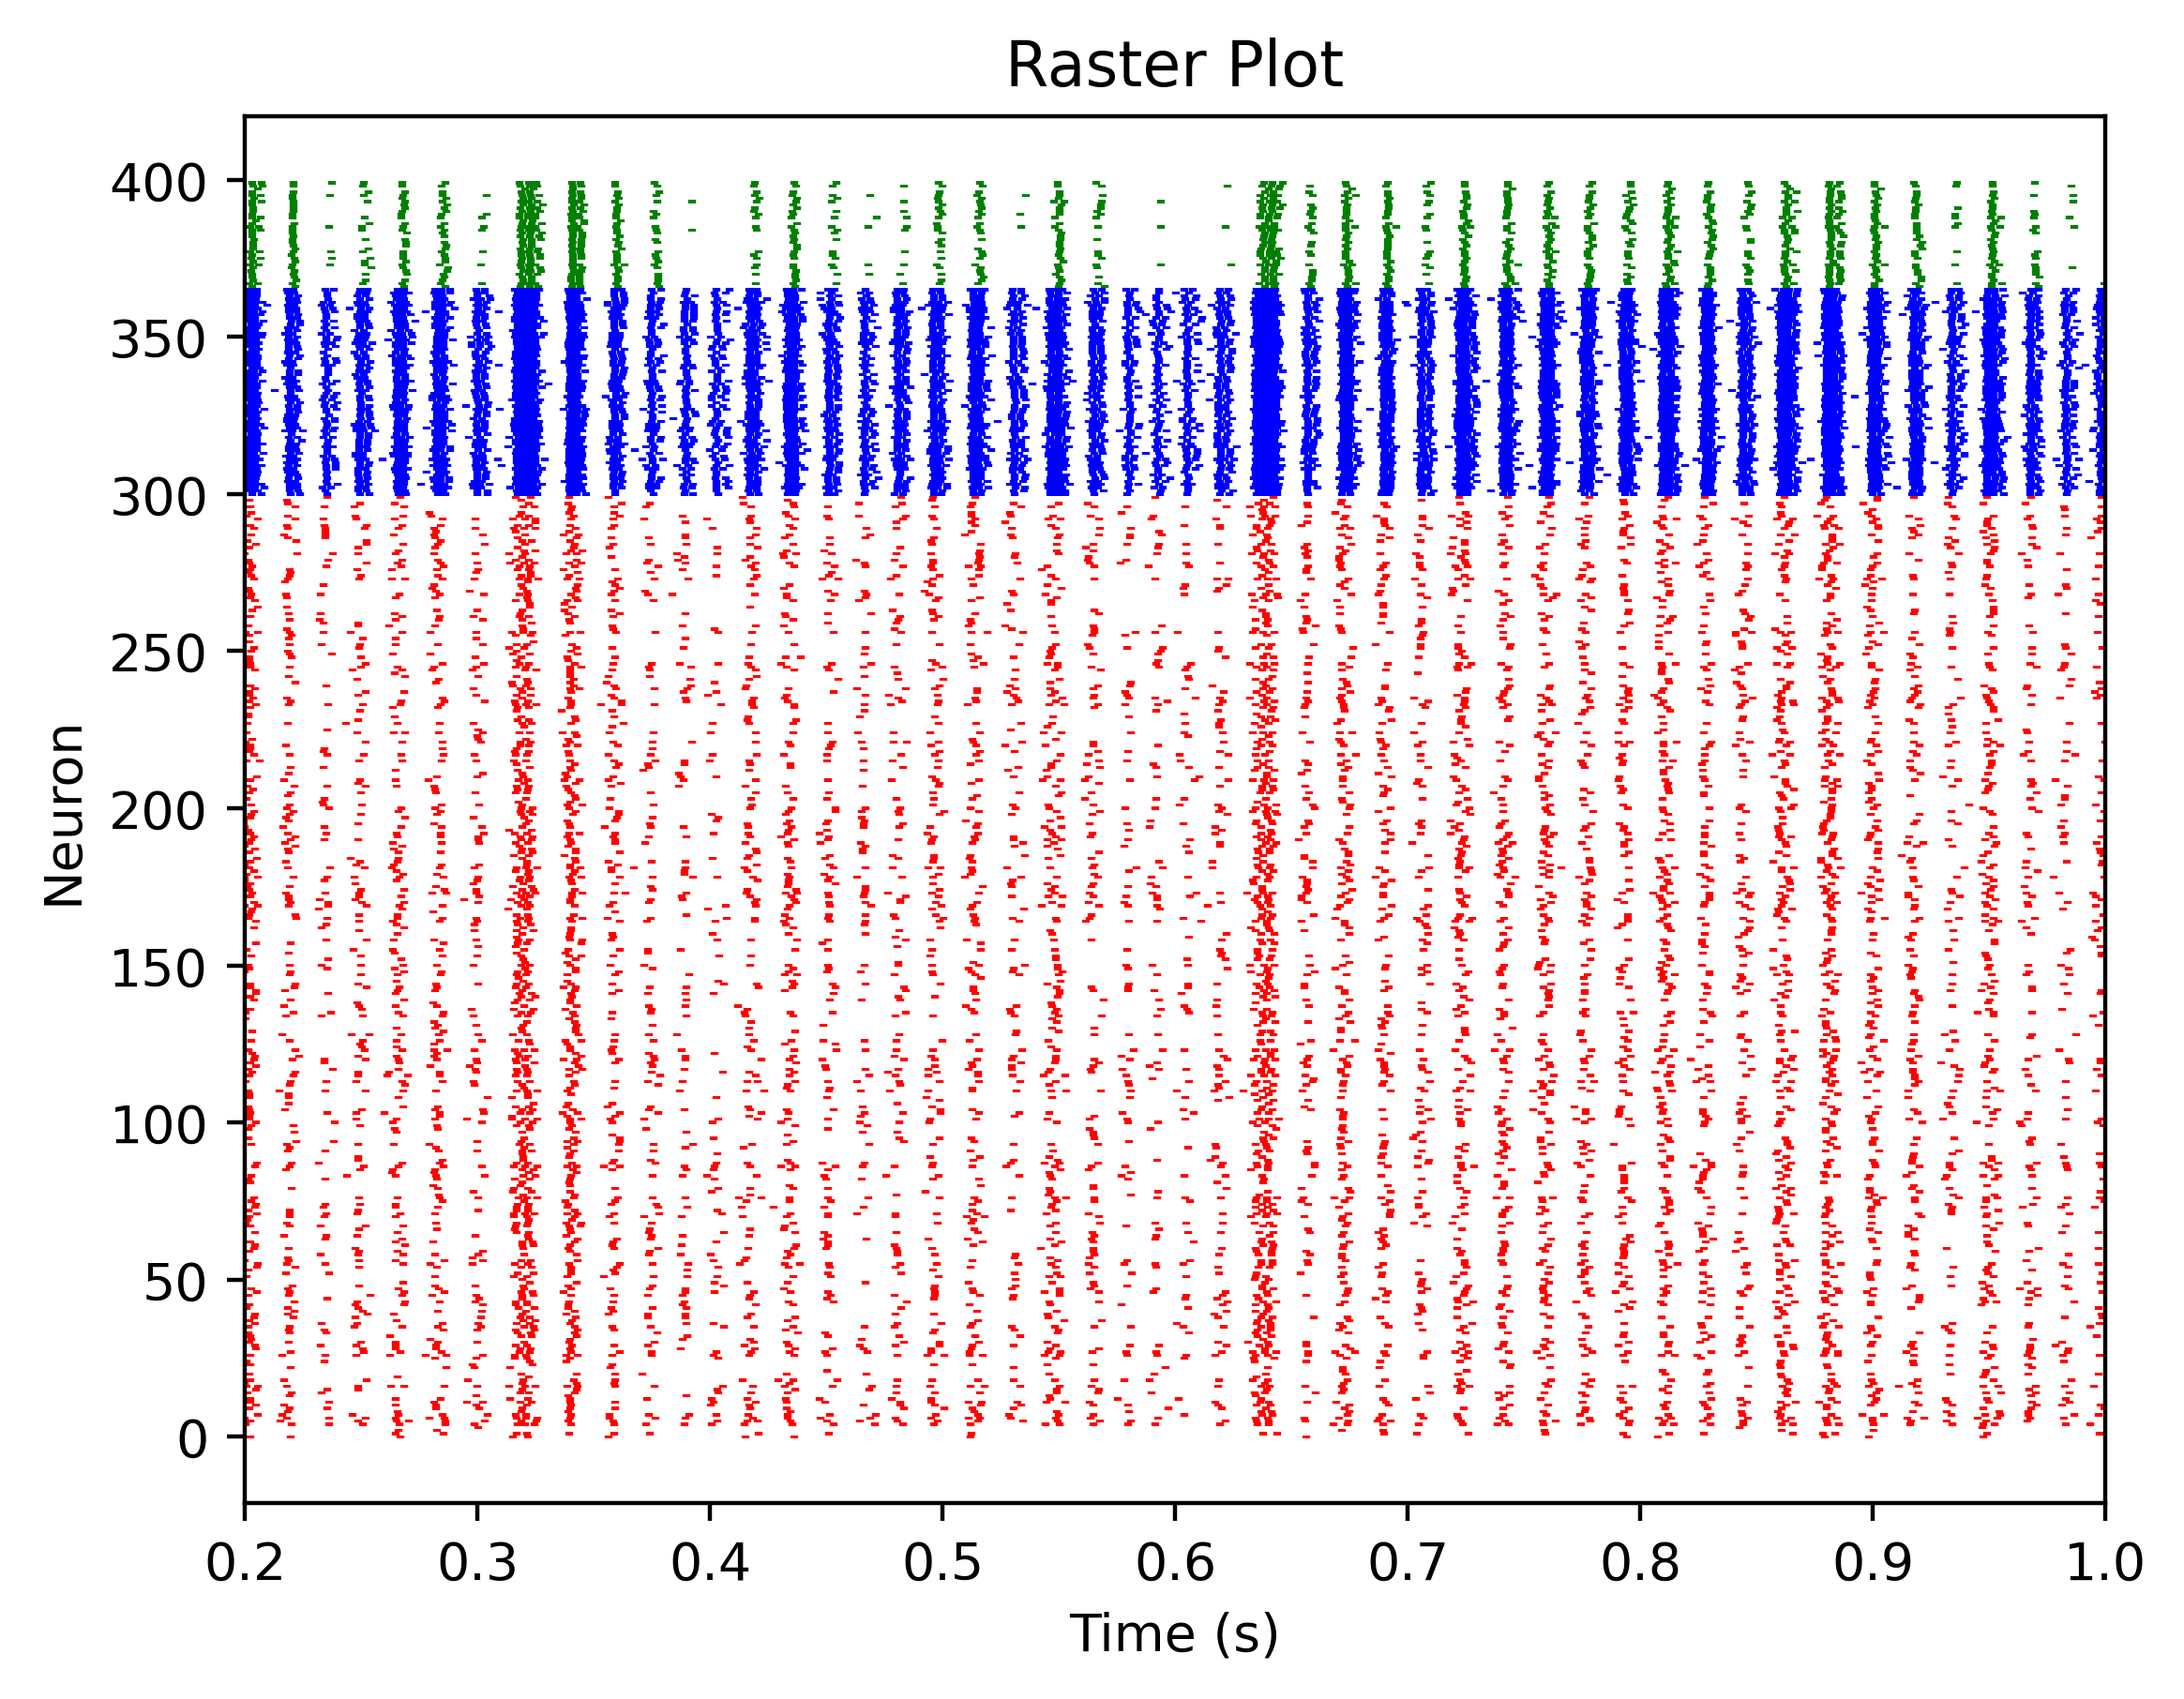

In [18]:
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 400
def create_raster(data, title):
    plt.eventplot(data, colors = ["red"]*num_E + ["blue"]*num_PV + ["green"]*num_SOM)
    plt.xlim(0.2, 1)
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron")
    plt.title(title);
create_raster(neurons['spike_times'], "Raster Plot")

In [86]:
from tqdm.notebook import tqdm

num_trials = 36
rates = np.zeros((3, num_trials))
transmitters = np.zeros((2, num_trials))
params = np.load('final_params.npy')
params[9] -= 0.7
params[10] -= 1.4
for i in tqdm(range(num_trials)):
    params[9] += 0.1
    params[10] += 0.2
    E_rate, PV_rate, SOM_rate, _, _, _, neurons, _ = run_simulation(params)
    transmitter_means = neurons['transmitter_means']
    transmitters[0, i] = np.mean(np.take(transmitter_means, [0, 1, 3, 4]))
    transmitters[1, i] = np.mean(np.take(transmitter_means, [2, 5, 6, 7, 8]))
    rates[0, i] = E_rate
    rates[1, i] = PV_rate
    rates[2, i] = SOM_rate

  0%|          | 0/36 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Increasing Feedforward Drive (Firing Rates)')

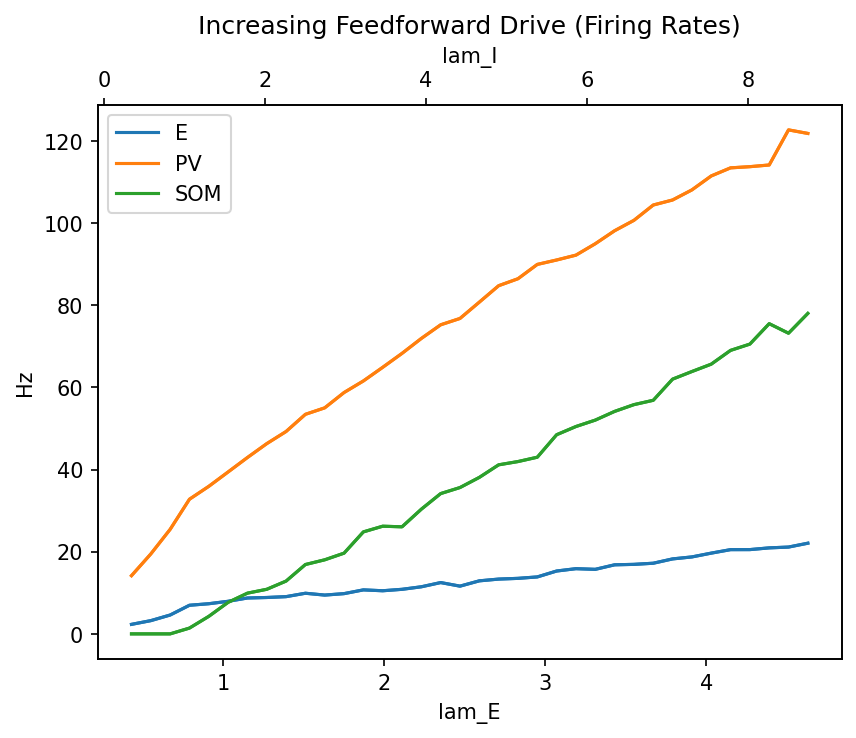

In [87]:
plt.rcParams['figure.dpi'] = 150
params = np.load('final_params.npy')
lam_E = np.linspace(params[9] - 0.6, params[9] + 0.1*num_trials, num_trials)
lam_I = np.linspace(params[10] - 1.2, params[10] + 0.2*num_trials, num_trials)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(lam_E, rates.T, label = ["E", "PV", "SOM"])
ax2.plot(lam_I, rates.T)
ax2.set_xlabel("lam_I")

ax1.set_xlabel("lam_E")
ax1.set_ylabel("Hz")
ax1.legend()
plt.title("Increasing Feedforward Drive (Firing Rates)")

(0.0, 6.0)

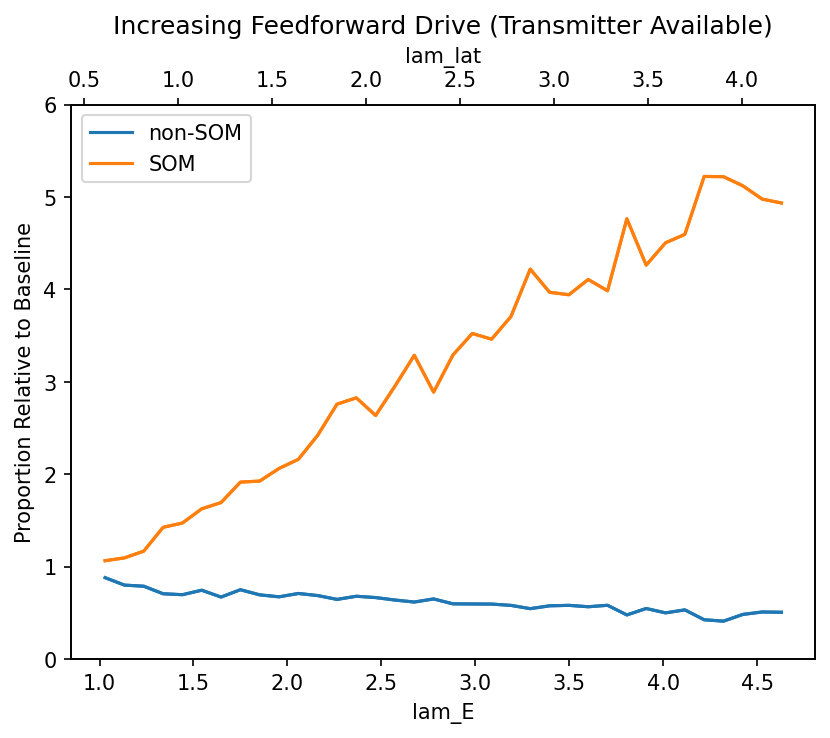

In [88]:
params = np.load('final_params.npy')
lam_E = np.linspace(params[9], params[9] + 0.1*num_trials, num_trials)
lam_lat = np.linspace(params[11], params[11] + 0.1*num_trials, num_trials)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(lam_E, transmitters.T, label = ["non-SOM", "SOM"])
ax2.plot(lam_lat, transmitters.T)
ax2.set_xlabel("lam_lat")

ax1.set_xlabel("lam_E")
ax1.set_ylabel("Proportion Relative to Baseline")
ax1.legend()
plt.title("Increasing Feedforward Drive (Transmitter Available)")
plt.ylim(0, 6)

In [101]:
num_trials = 36
rates = np.zeros((3, num_trials))
transmitters = np.zeros((2, num_trials))
params = np.load('final_params.npy')
params[9] -= 0.7
params[11] -= 0.7
for i in tqdm(range(num_trials)):
    params[9] += 0.1
    params[11] += 0.1
    E_rate, PV_rate, SOM_rate, _, _, _, neurons, _ = run_simulation(params)
    rates[0, i] = E_rate
    rates[1, i] = PV_rate
    rates[2, i] = SOM_rate
    transmitter_means = neurons['transmitter_means']
    transmitters[0, i] = np.mean(np.take(transmitter_means, [0, 1, 3, 4]))
    transmitters[1, i] = np.mean(np.take(transmitter_means, [2, 5, 6, 7, 8]))
    #transmitters[2, i] = np.mean(np.take(transmitter_means, [2, 5, 8]))

  0%|          | 0/36 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Increasing Lateral Drive (Firing Rates)')

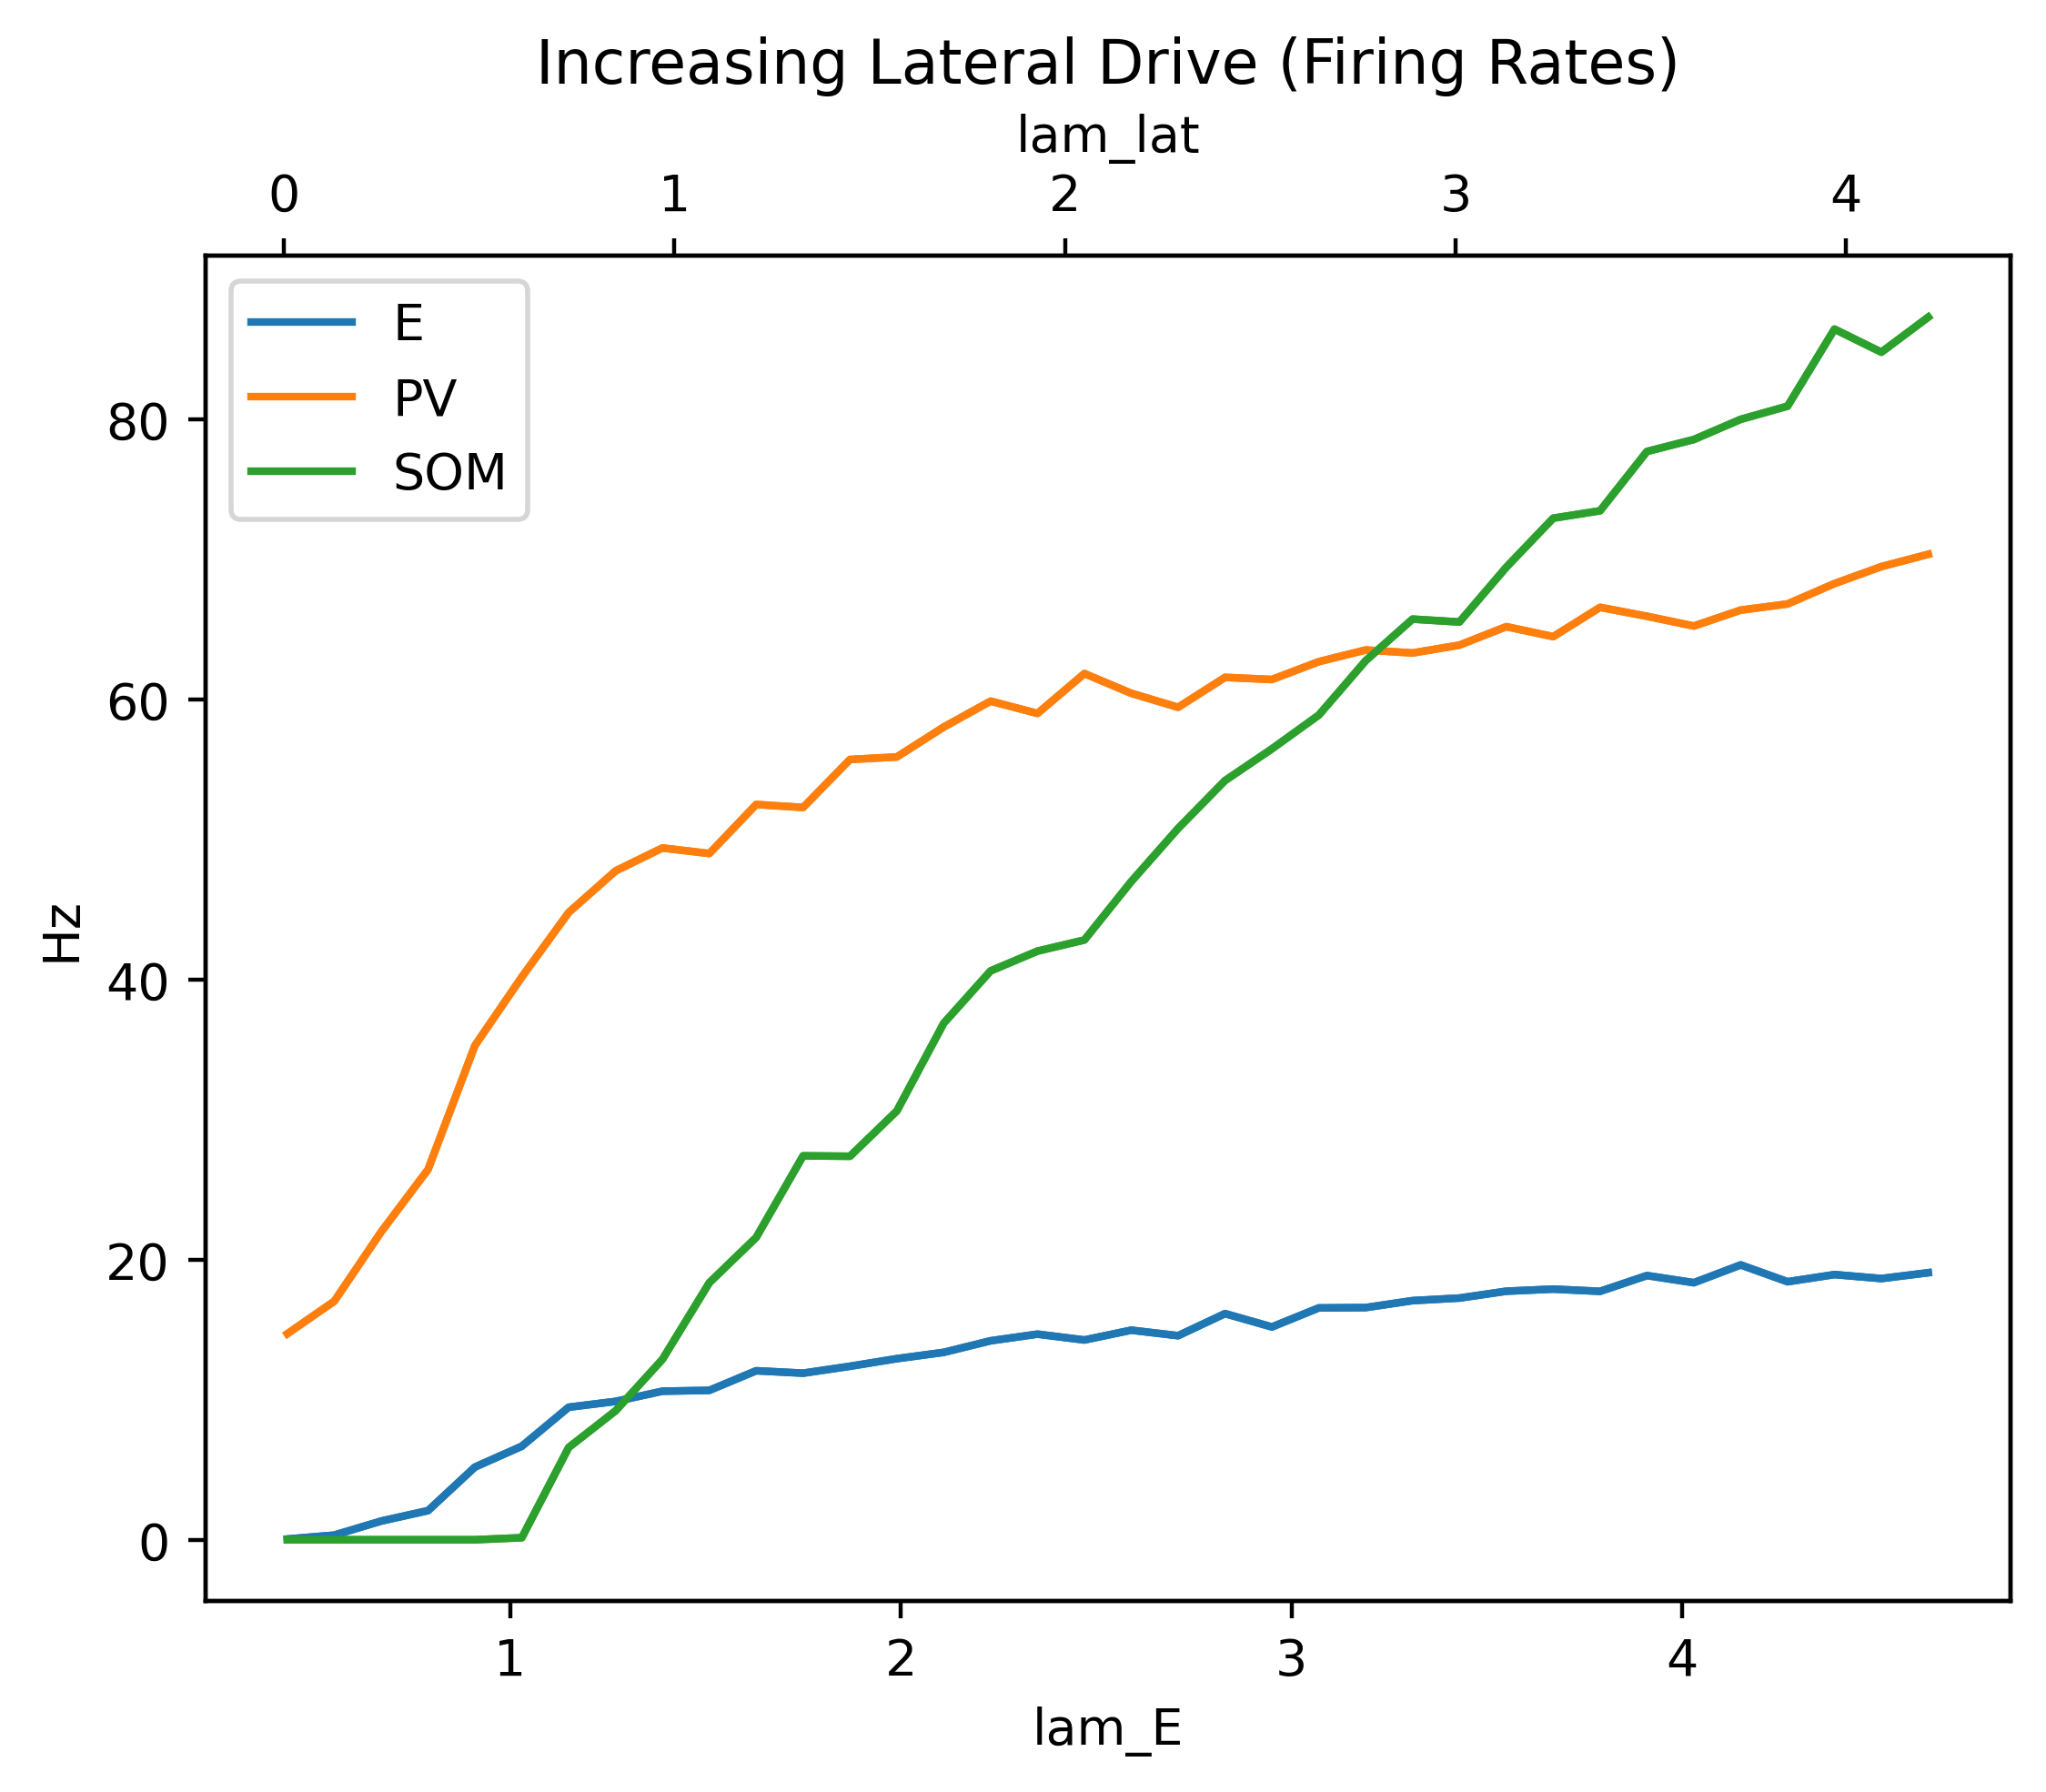

In [102]:
params = np.load('final_params.npy')
lam_E = np.linspace(params[9] - 0.6, params[9] + 0.1*num_trials, num_trials)
lam_lat = np.linspace(params[11] - 0.6, params[11] + 0.1*num_trials, num_trials)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(lam_E, rates.T, label = ["E", "PV", "SOM"])
ax2.plot(lam_lat, rates.T)
ax2.set_xlabel("lam_lat")

ax1.set_xlabel("lam_E")
ax1.set_ylabel("Hz")
ax1.legend()
plt.title("Increasing Lateral Drive (Firing Rates)")

(0.0, 6.0)

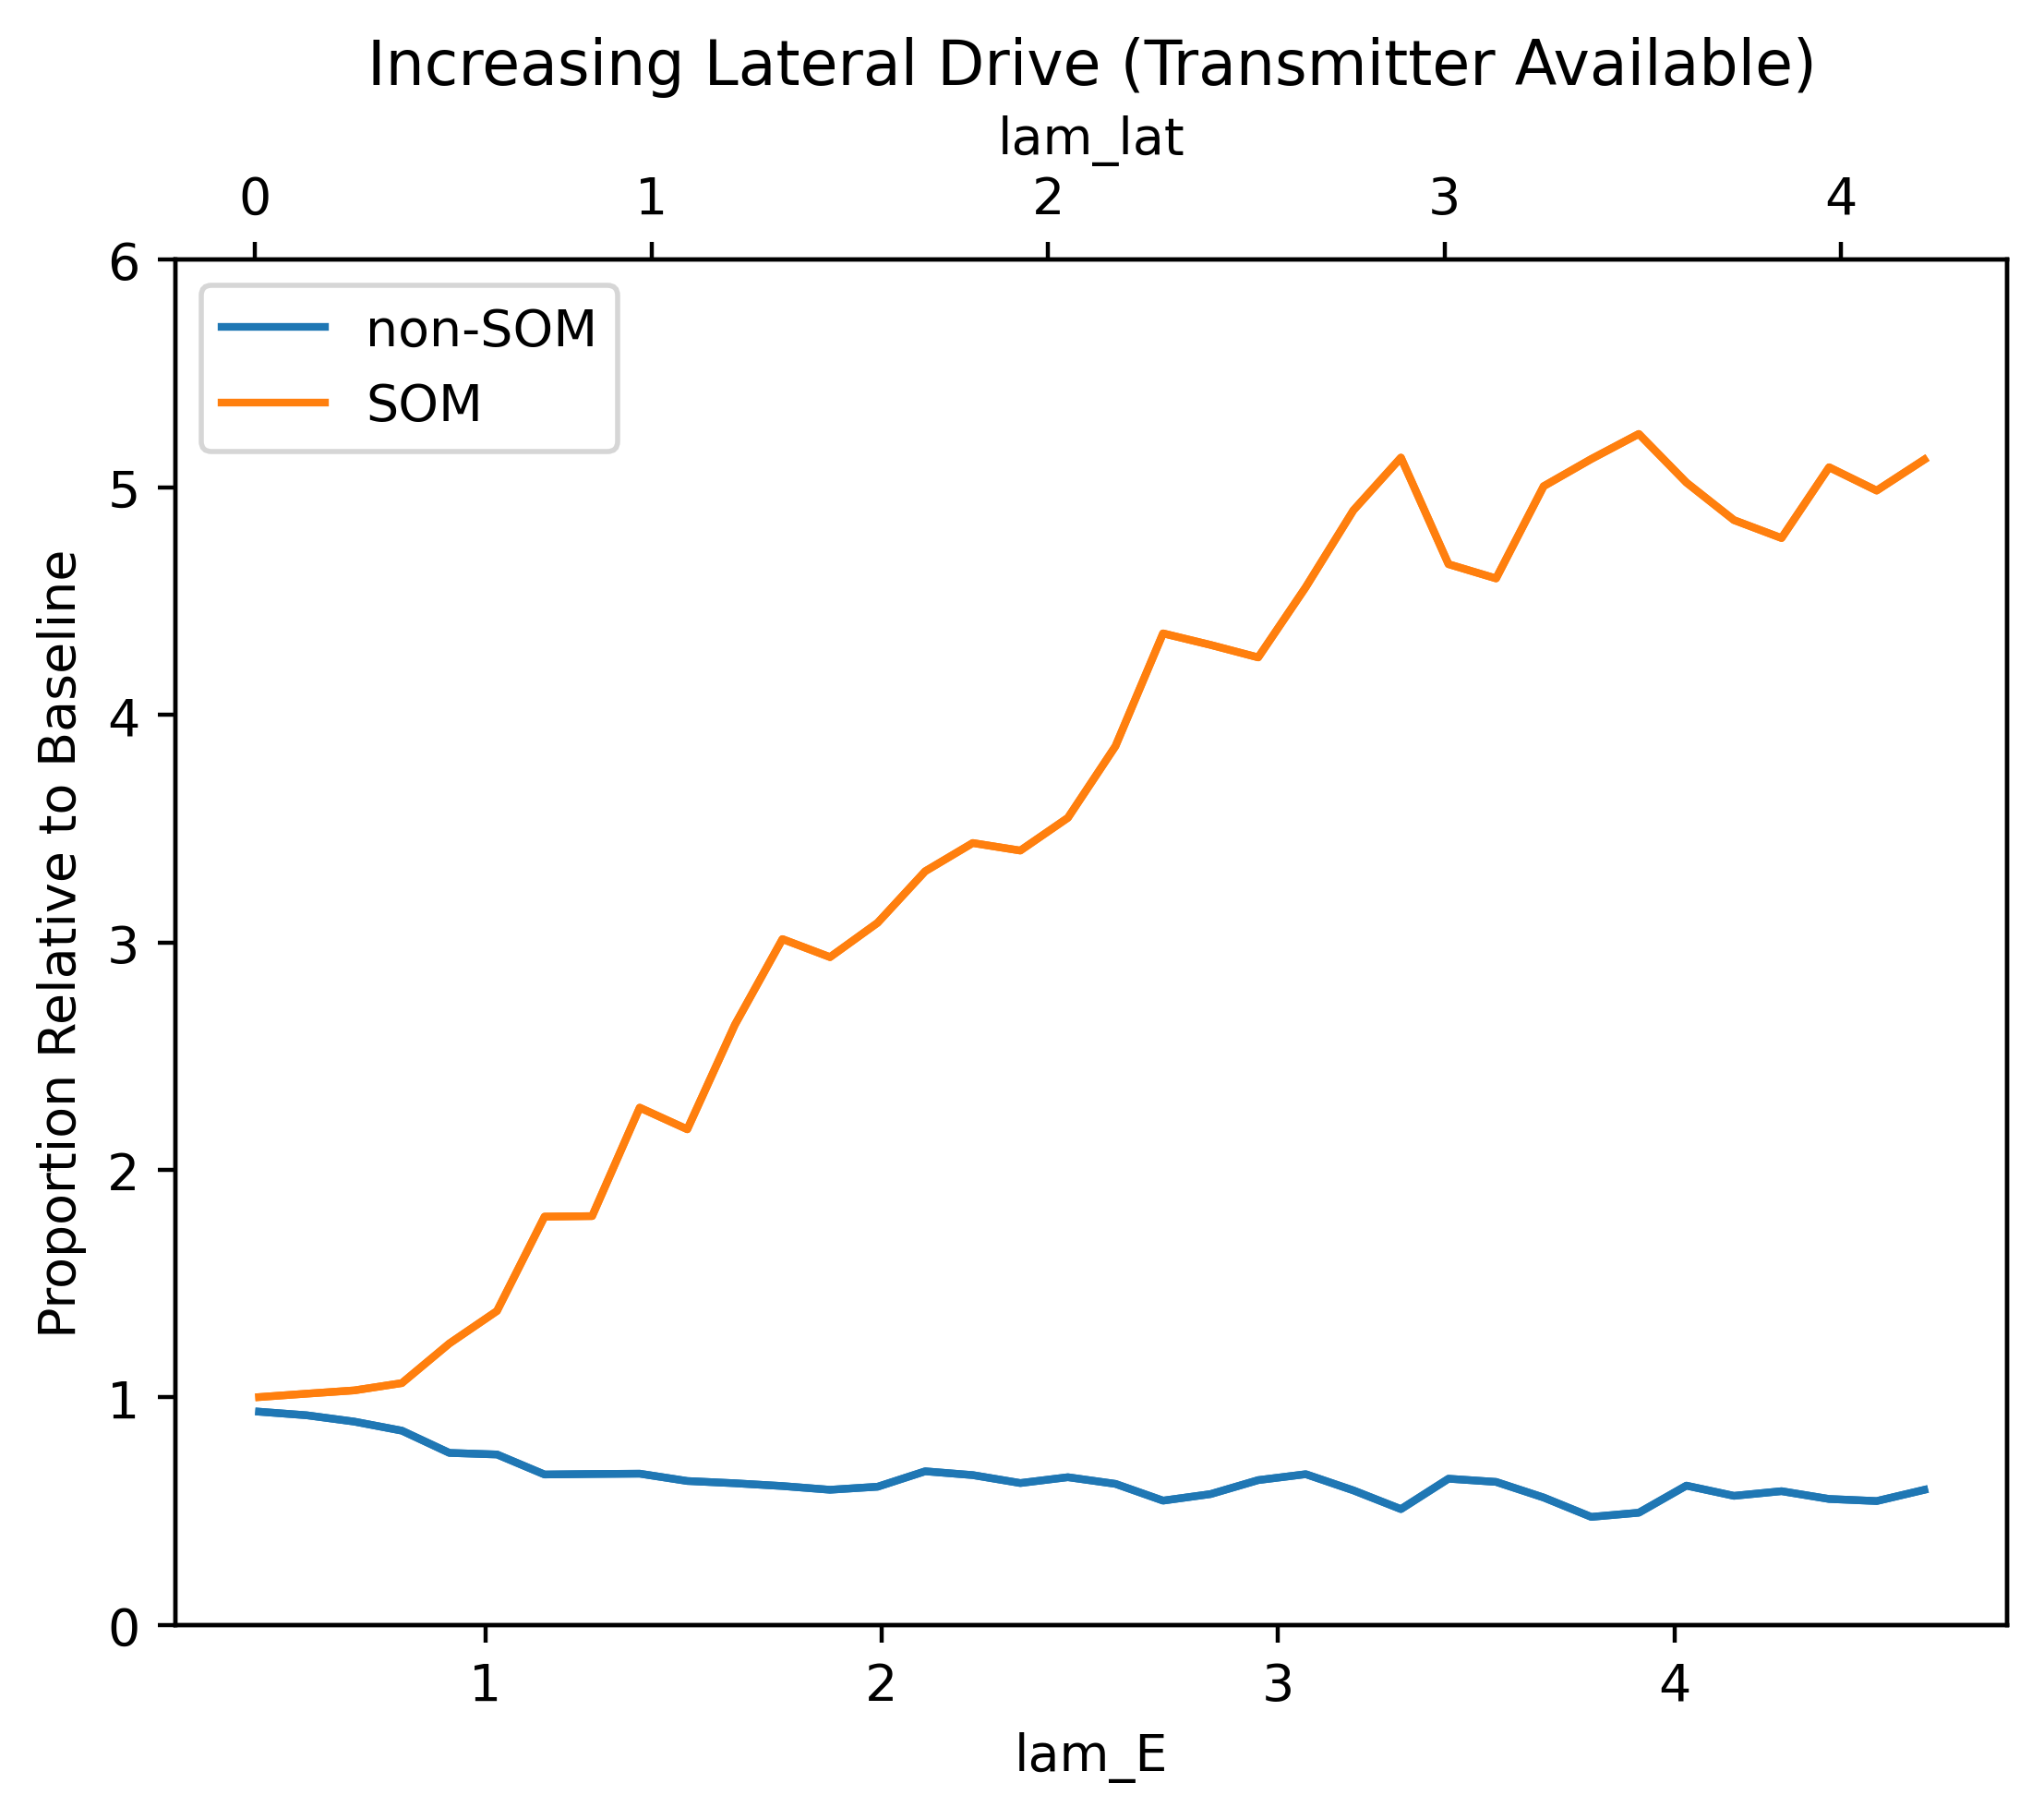

In [103]:
params = np.load('final_params.npy')
lam_E = np.linspace(params[9] - 0.6, params[9] + 0.1*num_trials, num_trials)
lam_lat = np.linspace(params[11] -0.6, params[11] + 0.1*num_trials, num_trials)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(lam_E, transmitters.T, label = ["non-SOM", "SOM"])
ax2.plot(lam_lat, transmitters.T)
ax2.set_xlabel("lam_lat")

ax1.set_xlabel("lam_E")
ax1.set_ylabel("Proportion Relative to Baseline")
ax1.legend()
plt.title("Increasing Lateral Drive (Transmitter Available)")
plt.ylim(0, 6)

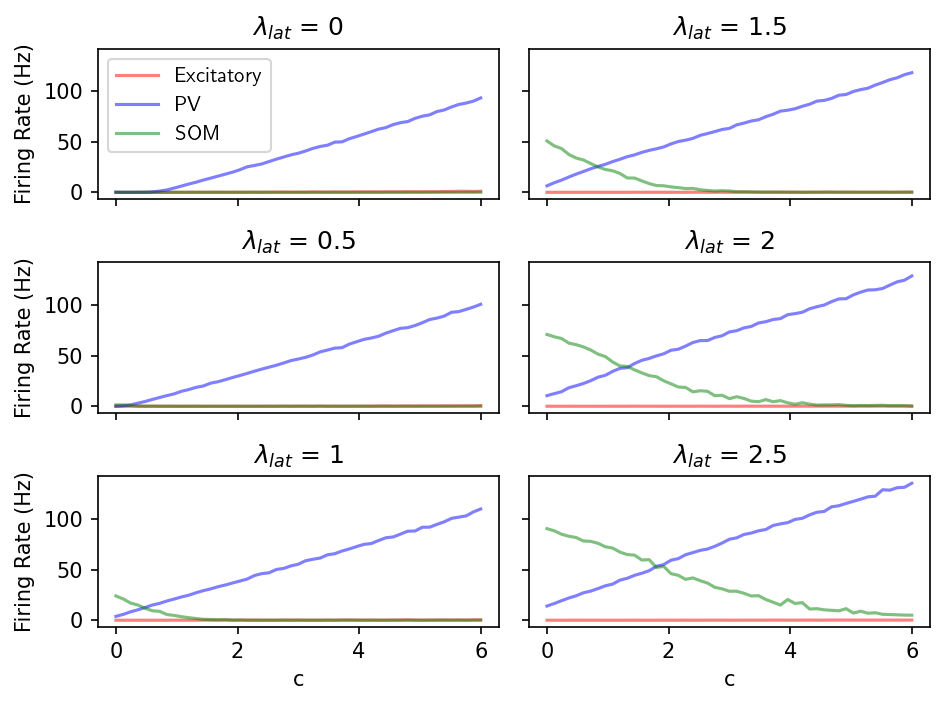

In [7]:
fig, ax = plt.subplots(len(lam_lats) //2, 2, sharex = True, sharey = True)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True
for i in range(len(lam_lats)):
    ax[i % 3, int(i >= 3)].plot(cs, rates[0, i], label = "Excitatory", color= 'r', alpha = 0.5)
    ax[i % 3, int(i >= 3)].plot(cs, rates[1, i], label = "PV", color = 'b', alpha = 0.5)
    ax[i % 3, int(i >= 3)].plot(cs, rates[2, i], label = "SOM", color = 'g', alpha = 0.5)
    ax[i % 3, int(i >= 3)].set_title(f"$\lambda_{{lat}}$ = {lam_lats[i]}")
    
ax[2, 1].set_xlabel("c")
ax[2, 0].set_xlabel("c")
ax[0, 0].legend()
ax[0, 0].set_ylabel("Firing Rate (Hz)")
ax[1, 0].set_ylabel("Firing Rate (Hz)")
ax[2, 0].set_ylabel("Firing Rate (Hz)")
fig.tight_layout()

In [23]:
from tqdm.notebook import tqdm

params = np.load('params.npy')
params[5] = 0
params[6] = 0
cs = np.linspace(1, 10, 91)
rates_nd = np.zeros((2, 91))
depressions_nd = np.zeros((2, 91))
# With depression
for i in tqdm(range(len(cs))):
    params[4] = cs[i]
    E_rate, I_rate, E_depression, I_depression, _ = run_simulation(params)
    rates_nd[0, i] = E_rate
    rates_nd[1, i] = I_rate
    depressions_nd[0, i] = E_depression
    depressions_nd[1, i] = I_depression

  0%|          | 0/91 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Network Dynamics without Synaptic Depression')

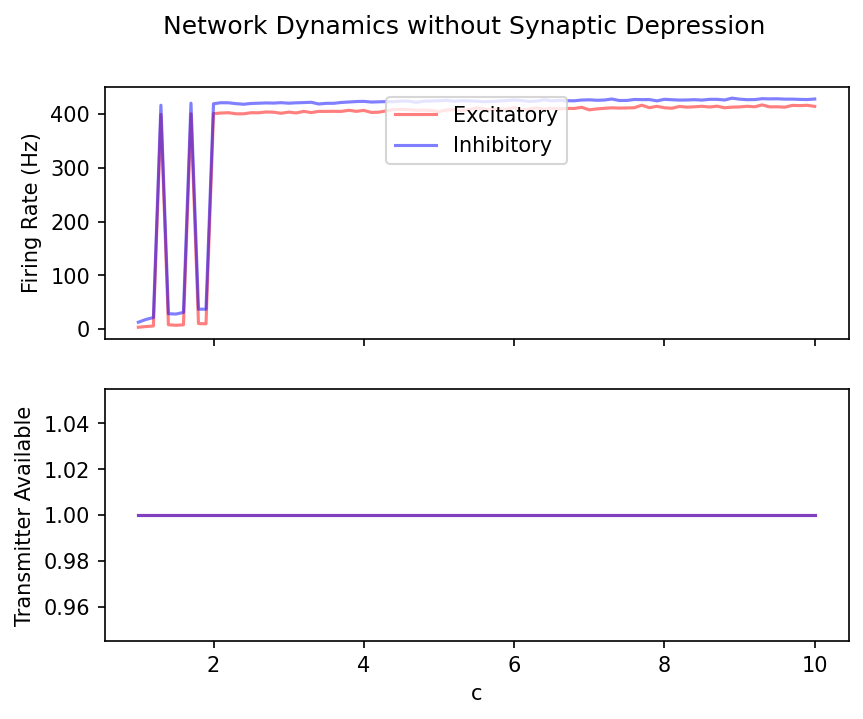

In [65]:
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots(2, sharex = True)

ax[0].plot(cs, rates_nd[0], label = "Excitatory", color= 'r', alpha = 0.5)
ax[0].plot(cs, rates_nd[1], label = "Inhibitory", color = 'b', alpha = 0.5)
ax[0].legend(loc='upper center')
ax[0].set_ylabel("Firing Rate (Hz)")
ax[1].plot(cs, depressions_nd[0], color = 'red', alpha = 0.5)
ax[1].plot(cs, depressions_nd[1], color = 'b', alpha = 0.5)
ax[1].set_xlabel("c")
ax[1].set_ylabel("Transmitter Available")
fig.suptitle("Network Dynamics without Synaptic Depression")

# Generate Data

In [3]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
import multiprocessing
import LIF_sim
import importlib
importlib.reload(LIF_sim)

if __name__ == "__main__":
    for i in tqdm(range(0, 1)):
        np.random.seed(i)
        num_simulations = 1000
        with multiprocessing.Pool(processes = os.cpu_count() - 2) as pool:
            results = list(tqdm(pool.imap(LIF_sim.run_one_simulation, range(num_simulations)), total=num_simulations))
        param_list, data = zip(*results)
        param_list = np.array(param_list)
        data = np.array(data)
        with open(f'LIF_sims_{i + 1}.pkl', 'wb') as handle:
            pickle.dump([param_list, data], handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [142]:
param_list.shape

(10000, 19)

In [143]:
data.shape

(10000, 12)

In [41]:
num_blocks = 2
data_per_block = 10000
N = num_blocks * data_per_block
num_params = 19
num_outputs = 3
device = 'cuda'

param_sets = np.zeros((N, num_params))
outputs = np.zeros((N, num_outputs))
for i in range(num_blocks):
    with open(f'LIF_sims_{i+1}.pkl', 'rb') as handle:
        param_set, output = pickle.load(handle)
        param_sets[i * data_per_block : (i+1) * data_per_block] = param_set
        outputs[i * data_per_block : (i+1) * data_per_block] = output

In [42]:
outputs

array([[1.82000000e+00, 8.42727273e+01, 3.70588235e+00],
       [1.53333333e+01, 6.98787879e+01, 3.97647059e+01],
       [4.00000000e-02, 4.26060606e+01, 0.00000000e+00],
       ...,
       [1.93333333e-01, 5.66515152e+01, 5.88235294e-02],
       [6.00000000e-01, 1.19848485e+01, 3.23529412e-01],
       [4.66666667e-02, 3.72424242e+01, 0.00000000e+00]])